In [24]:
import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.qmc import Sobol
import torch
from tqdm.notebook import tqdm

from gekko import GEKKO
from jtoolbox.logger import H5Logger
from sekf.modeling import AbstractNN

from TCLab import *

%matplotlib inline

In [25]:
run_1 = {
    "begin_time": datetime.datetime(2025, 4, 15, 17, 5, 35),
    "begin_n": 2077,
    "end_time": datetime.datetime(2025, 4, 15, 17, 17, 45),
    "end_n": 3111,
    "job_number": 2328309,
}
run_2 = {
    "begin_time": datetime.datetime(2025, 4, 15, 19, 23, 34),
    "begin_n": 3111,
    "end_time": datetime.datetime(2025, 4, 16, 5, 23, 49),
    "end_n": 35405,
    "job_number": 2328521,
}
run_3 = {
    "begin_time": datetime.datetime(2025, 4, 16, 8, 46, 39),
    "begin_n": 58522,
    "end_time": datetime.datetime(2025, 4, 16, 10, 2, 46),
    "end_n": 65536,
    "job_number": 2328994,
}
run = run_1
tps1 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
run = run_2
tps2 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
run = run_3
tps3 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
print(f"tps1: {tps1}, tps2: {tps2}, tps3: {tps3}")

tps1: 0.7059961315280464, tps2: 1.1152226419768378, tps3: 0.6511263187909895


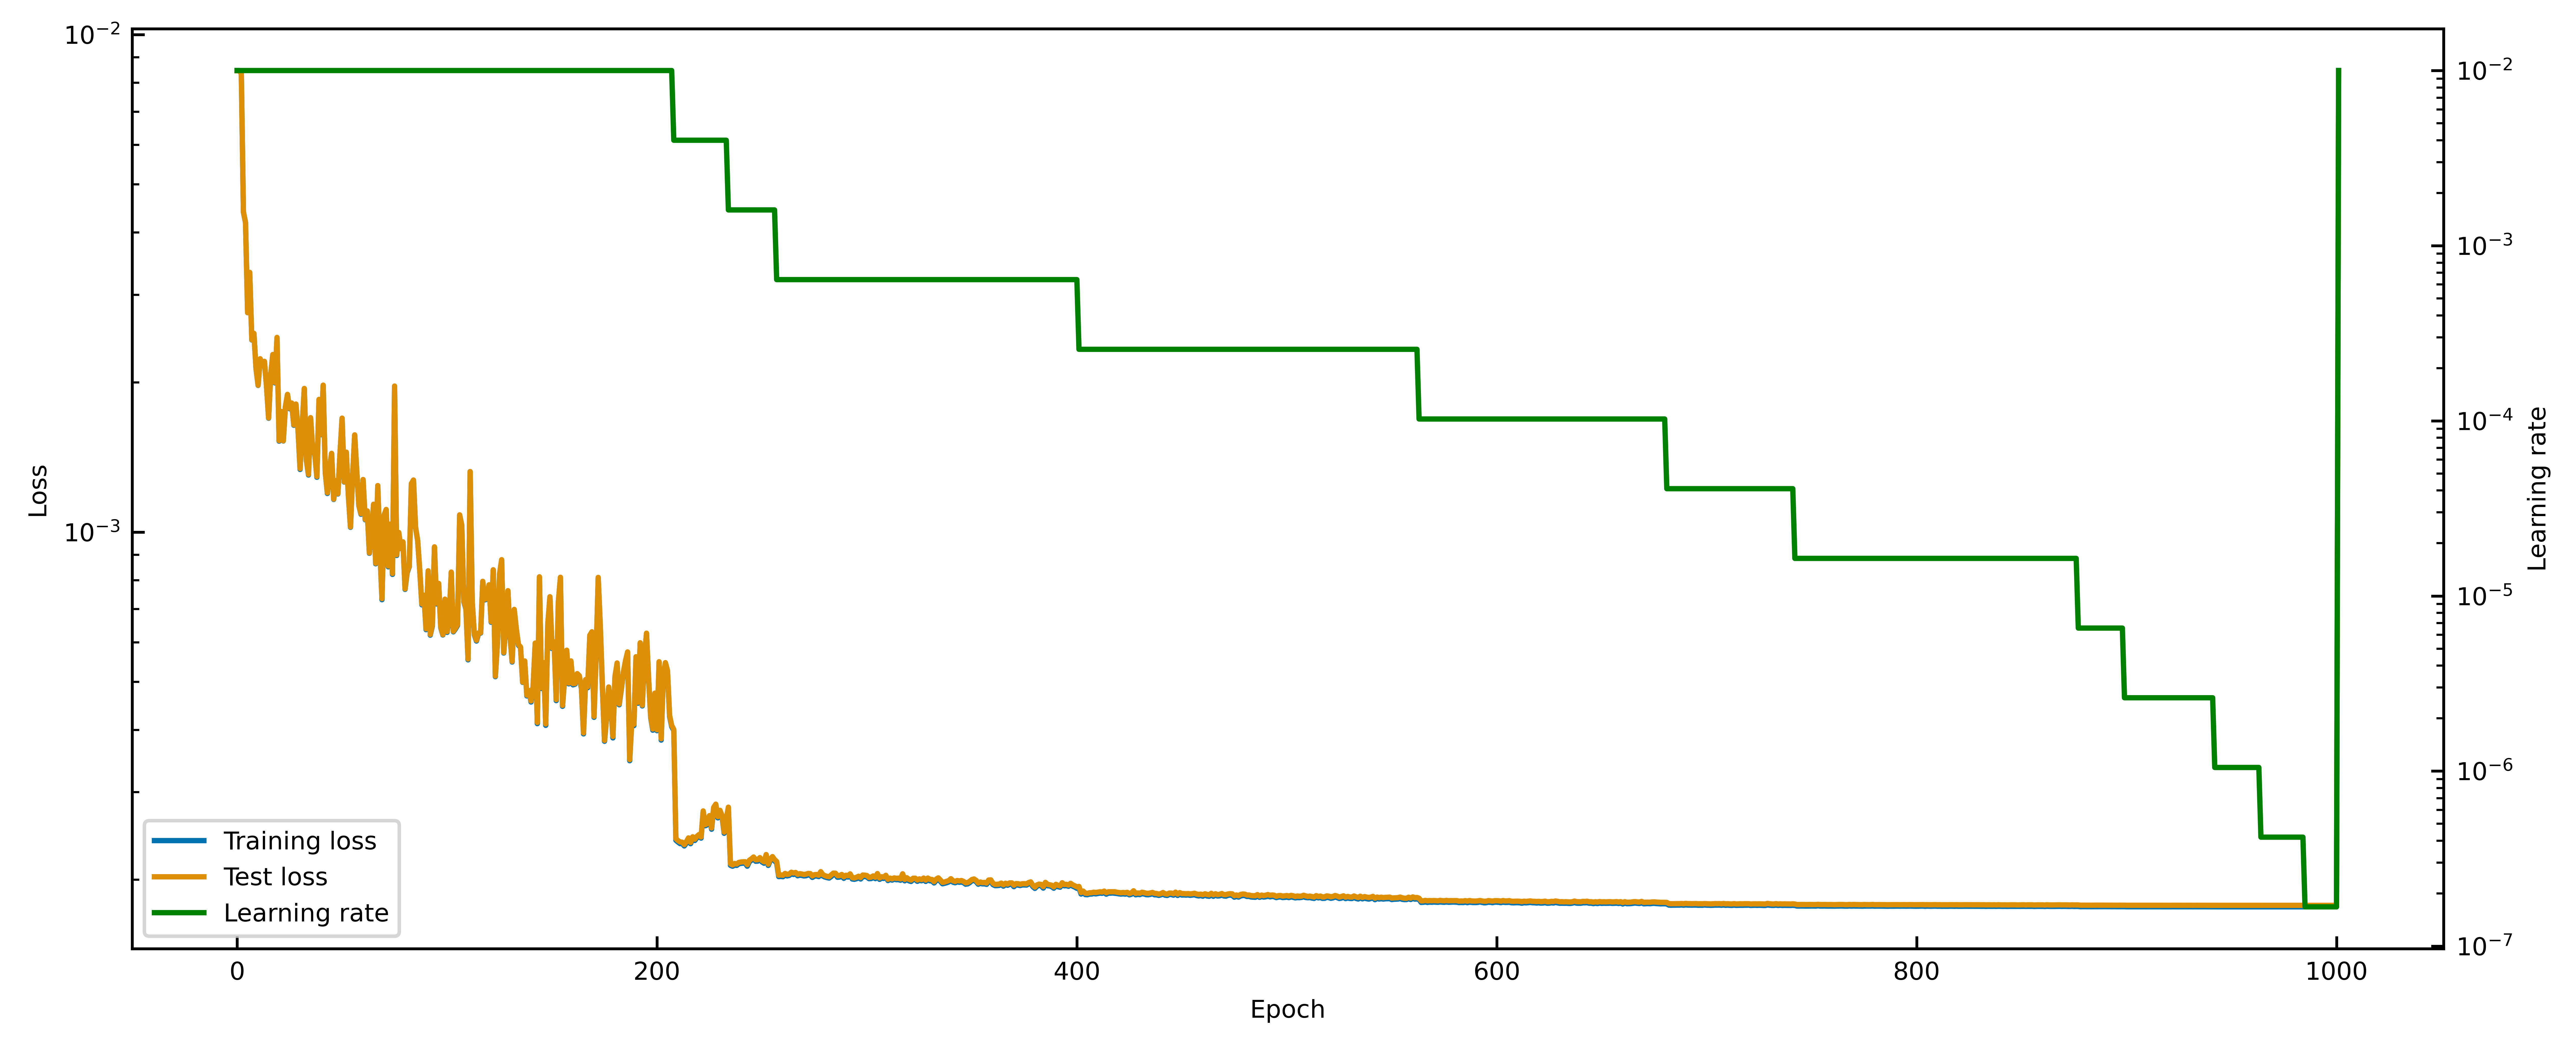

In [26]:
train_dataset = TCLabDataset(logger, prefix="data/train/")
test_dataset = TCLabDataset(logger, prefix="data/test/")

training_losses = logger.get_dataset("training/v0/loss/train")
test_losses = logger.get_dataset("training/v0/loss/test")
learning_rates = logger.get_dataset("training/v0/lr")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
(l1,) = ax.plot(training_losses, label="Training loss")
(l2,) = ax.plot(test_losses, label="Test loss")
ax.set_yscale("log")
ax2 = ax.twinx()
(l3,) = ax2.plot(learning_rates, label="Learning rate", color="green")
ax2.set_yscale("log")

ax.legend(handles=[l1, l2, l3])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax2.set_ylabel("Learning rate")
plt.show()

In [27]:
# TODO: would be nice to plot the simulated outcomes of the optimal / model outputs

NN = torch.load("TCLab_NNv0.pt", weights_only=False)

t10, t20, t1sp, t2sp, q1, q2 = test_dataset.__getitem__(2)
# t10, t20, t1sp, t2sp, q1, q2 = train_dataset.__getitem__(0)
q1_p, q2_p = NN(t10, t20, t1sp, t2sp)
q1_p = q1_p.detach().numpy()
q2_p = q2_p.detach().numpy()

t10 = test_dataset._Tunscale(t10).numpy()
t20 = test_dataset._Tunscale(t20).numpy()
t1sp = test_dataset._Tunscale(t1sp).numpy()
t2sp = test_dataset._Tunscale(t2sp).numpy()
q1 = test_dataset._Qunscale(q1).numpy()
q2 = test_dataset._Qunscale(q2).numpy()
q1_p = test_dataset._Qunscale(q1_p)
q2_p = test_dataset._Qunscale(q2_p)

t = np.linspace(0, 30, 61)

t1_sim_mpc, t2_sim_mpc = tclab_sim(t10, t20, q1, q2)
t1_sim_nn, t2_sim_nn = tclab_sim(t10, t20, q1_p, q2_p)


In [28]:
with plt.rc_context(
    {
        "font.size": 14,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].scatter(0, t10, color="r", marker="o", label=r"$T_1^0$")
    ax[0].scatter(0, t20, color="b", marker="o", label=r"$T_2^0$")
    ax[0].step(t, t1sp, "r--", where="mid", label=r"$T_1^{sp}$")
    ax[0].step(t, t2sp, "b--", where="mid", label=r"$T_2^{sp}$")
    ax[0].plot(t, t1_sim_mpc, "r-", label=r"$T_1^{sim}$ (MPC)")
    ax[0].plot(t, t2_sim_mpc, "b-", label=r"$T_2^{sim}$ (MPC)")
    ax[0].scatter(t, t1_sim_nn, edgecolor="r", facecolor="none", label=r"$T_1^{sim}$ (NN)")
    ax[0].scatter(t, t2_sim_nn, edgecolor="b", facecolor="none", label=r"$T_2^{sim}$ (NN)")
    ax[0].set_ylim(20, 47)
    ax[0].set_xticks(np.arange(0, 30 + 1, 5))
    ax[0].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
    ax[0].legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1.01), edgecolor="none")
    ax[0].set_ylabel("Temperature (°C)")

    ax[1].step(t, q1, "r-", where="mid", label=r"$Q_1$ (MPC)")
    ax[1].step(t, q2, "b-", where="mid", label=r"$Q_2$ (MPC)")
    ax[1].scatter(t, q1_p, edgecolor="r", facecolor="none", label=r"$Q_1$ (NN)")
    ax[1].scatter(t, q2_p, edgecolor="b", facecolor="none", label=r"$Q_2$ (NN)")
    ax[1].set_ylim(-1, 101)
    ax[1].set_xticks(np.arange(0, 30 + 1, 5))
    ax[1].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
    ax[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, 1.01), edgecolor="none")
    ax[1].set_ylabel("Heater Power (%)")
    ax[1].set_xlabel("Time (minutes)")

    fig.savefig("fig.png")

Exception ignored in: <generator object GK_Value.__iter__ at 0x162399490>
Traceback (most recent call last):
  File "/Users/jeh/anaconda3/envs/sekf/lib/python3.12/site-packages/matplotlib/cbook.py", line 1740, in _safe_first_finite
    return val
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object GK_Value.__iter__ at 0x162399490>
Traceback (most recent call last):
  File "/Users/jeh/anaconda3/envs/sekf/lib/python3.12/site-packages/matplotlib/units.py", line 67, in _is_natively_supported
    return isinstance(thisx, Number) and not isinstance(thisx, Decimal)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object GK_Value.__iter__ at 0x16dbbbc60>
Traceback (most recent call last):
  File "/Users/jeh/anaconda3/envs/sekf/lib/python3.12/site-packages/matplotlib/cbook.py", line 1740, in _safe_first_finite
    return val
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object GK_Value.__iter__ at 0

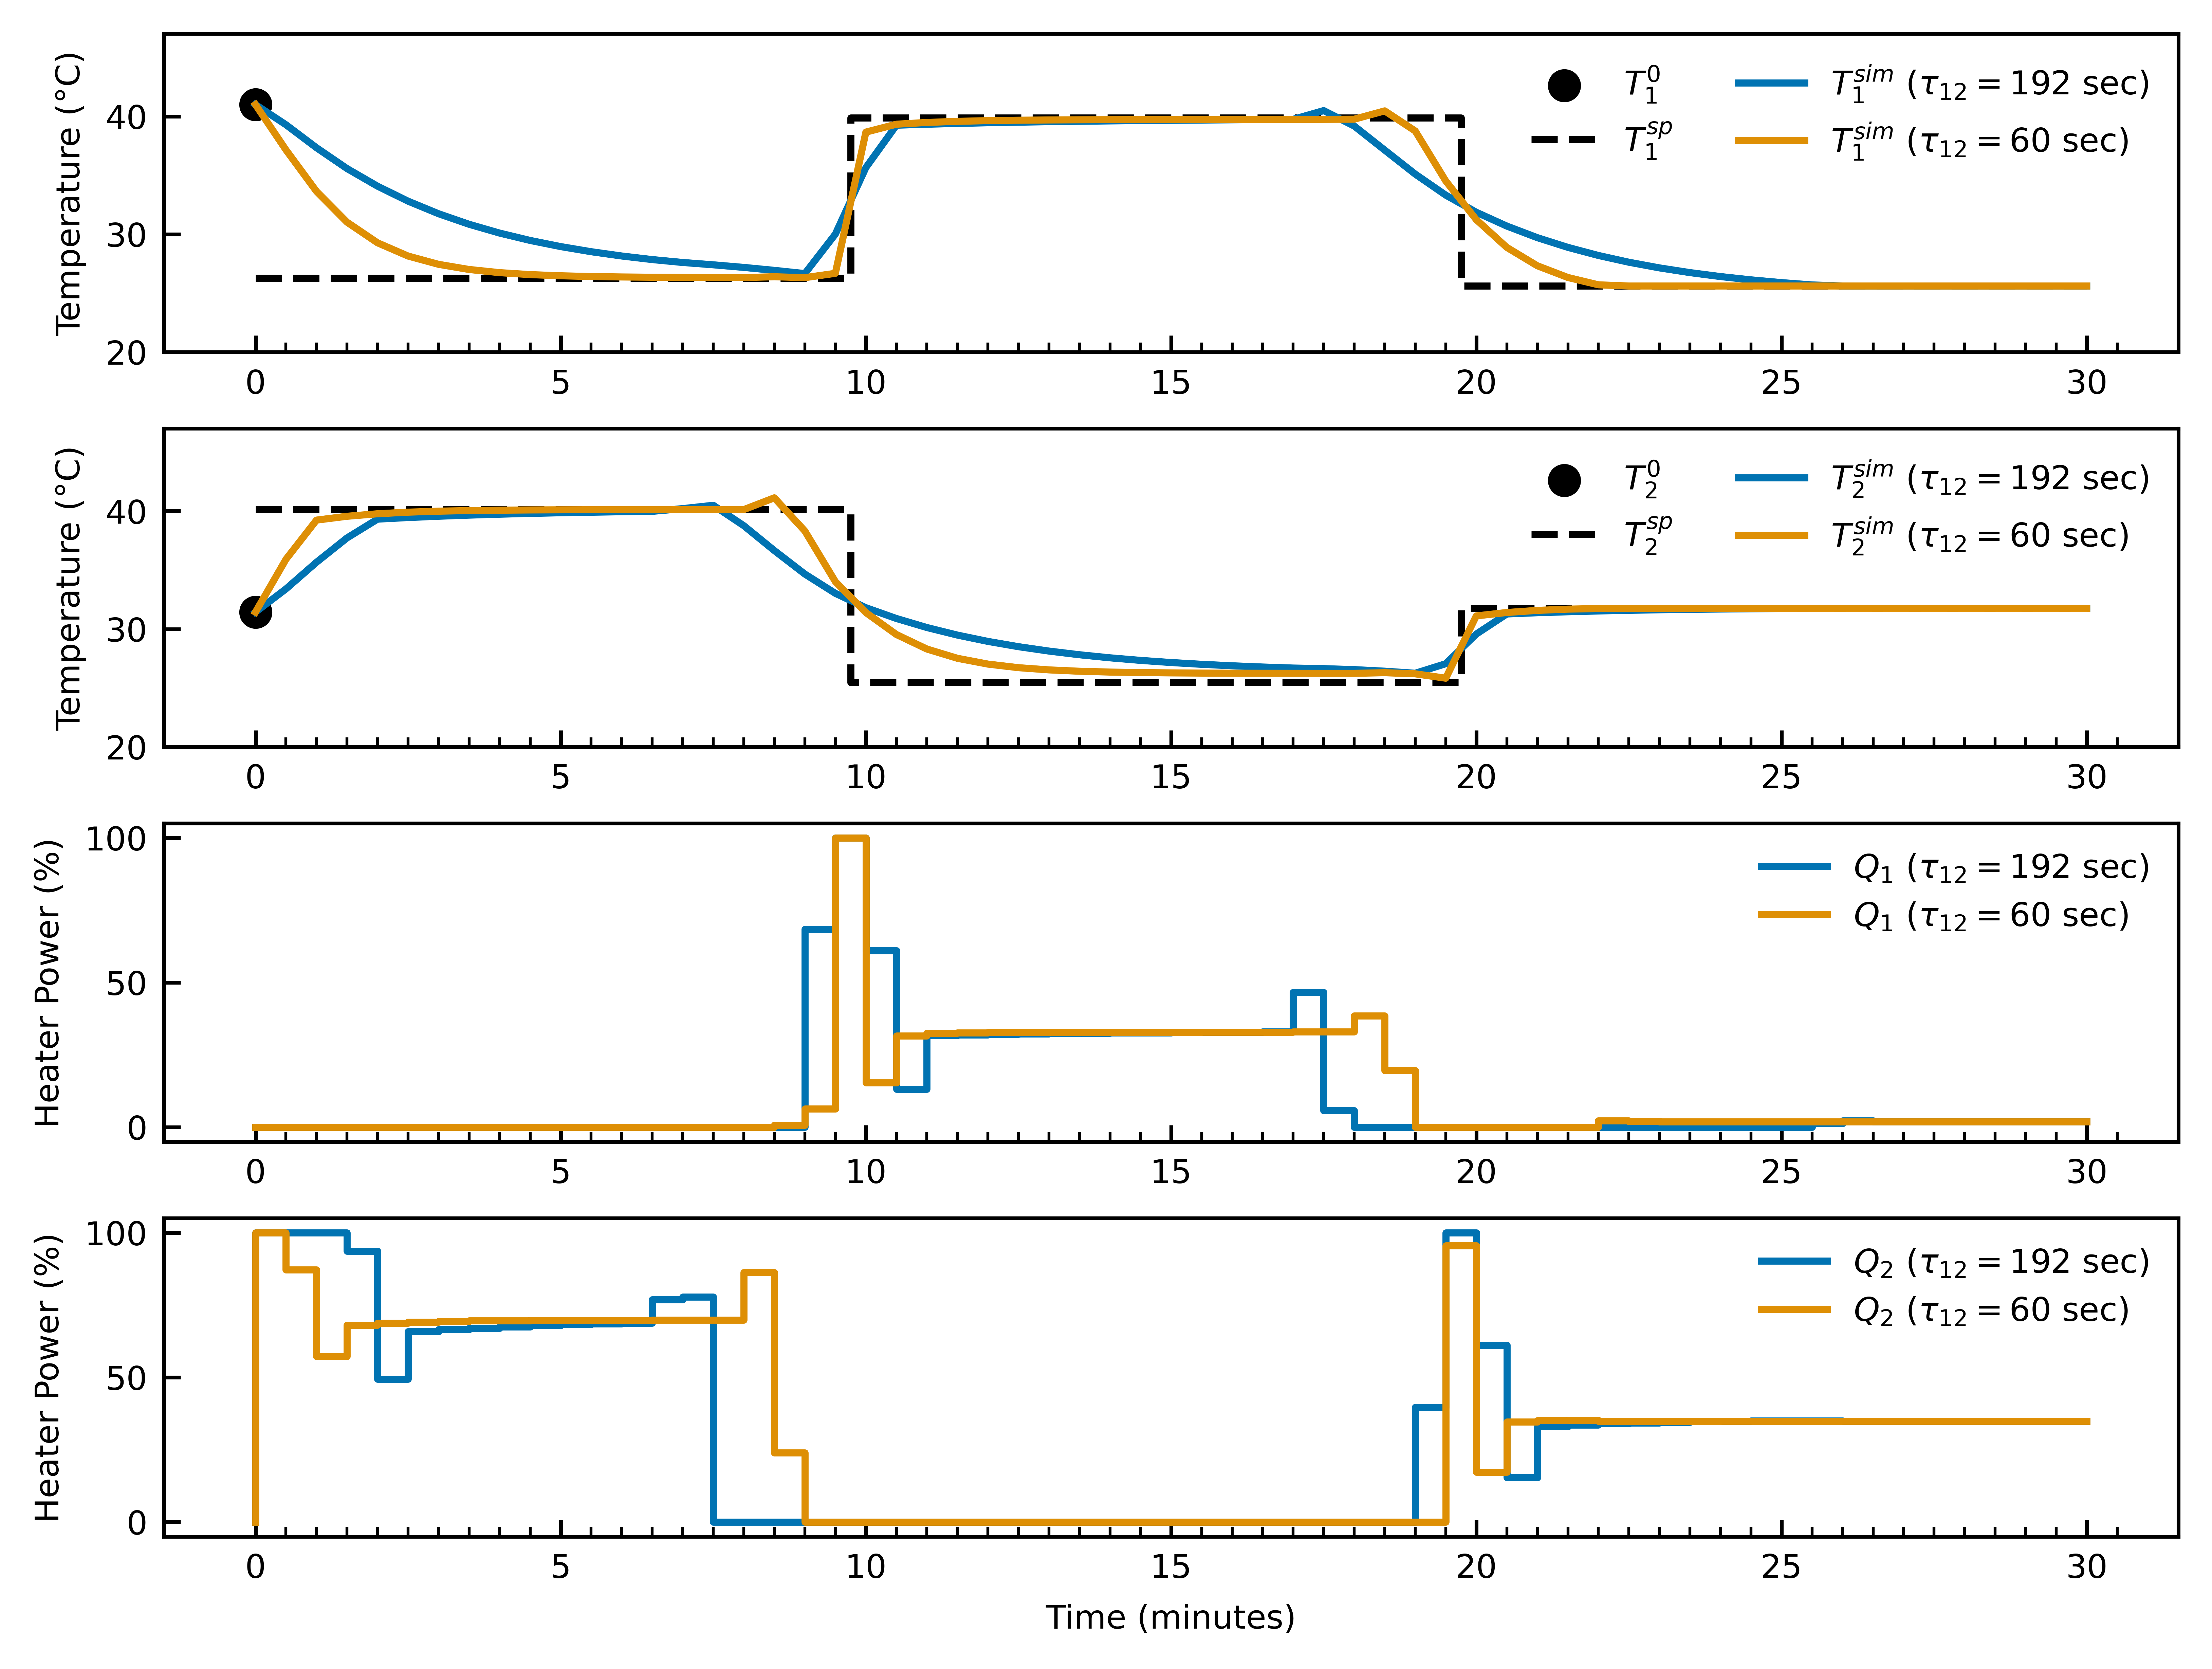

In [29]:
# colors = plt.colormaps["tab20c"].colors
import seaborn as sns

colors = sns.color_palette("colorblind", 2)
# sp1_color = colors[0]
sp1_color = "black"
# sp2_color = colors[8]
sp2_color = "black"
t1_sys1_color = colors[0]
t2_sys1_color = colors[0]
t1_sys2_color = colors[1]
t2_sys2_color = colors[1]

t10, t20, t1sp, t2sp, q1, q2 = test_dataset.__getitem__(1)

t10 = test_dataset._Tunscale(t10).numpy()
t20 = test_dataset._Tunscale(t20).numpy()
t1sp = test_dataset._Tunscale(t1sp).numpy()
t2sp = test_dataset._Tunscale(t2sp).numpy()
q1 = test_dataset._Qunscale(q1).numpy()
q2 = test_dataset._Qunscale(q2).numpy()

q1_sys1, q2_sys1, tc1_sys1, tc2_sys1 = TCLab_mpc_result(t10, t20, t1sp, t2sp)
q1_sys2, q2_sys2, tc1_sys2, tc2_sys2 = TCLab_mpc_result(t10, t20, t1sp, t2sp, tau12=60)

fig, ax = plt.subplots(4, 1)

ax[0].scatter(0, t10, color=sp1_color, marker="o", label=r"$T_1^0$")
# ax[0].scatter(0, t20, color=sp2_color, marker="o", label=r"$T_2^0$")
ax[0].step(t, t1sp, color=sp1_color, linestyle="--", where="mid", label=r"$T_1^{sp}$")
# ax[0].step(t, t2sp, color=sp2_color, linestyle="-", where="mid", label=r"$T_2^{sp}$")
ax[0].plot(t, tc1_sys1, color=t1_sys1_color, linestyle="-", label=r"$T_1^{sim}$ ($\tau_{12}=192$ sec)")
# ax[0].plot(t, tc2_sys1, color=t2_sys1_color, linestyle="-", label=r"$T_2^{sim}$ (sys2)")
ax[0].plot(t, tc1_sys2, color=t1_sys2_color, linestyle="-", marker="none", label=r"$T_1^{sim}$ ($\tau_{12}=60$ sec)")
# ax[0].plot(t, tc2_sys2, color=t2_sys2_color, linestyle="-", marker="x", label=r"$T_2^{sim}$ (sys2)")
ax[0].set_xticks(np.arange(0, 30 + 1, 5))
ax[0].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[0].legend(loc="upper right", ncol=2, edgecolor="none")
ax[0].set_ylabel("Temperature (°C)")
ax[0].set_ylim(20, 47)

# ax[1].scatter(0, t10, color=sp1_color, marker="o", label=r"$T_1^0$")
ax[1].scatter(0, t20, color=sp2_color, marker="o", label=r"$T_2^0$")
# ax[1].step(t, t1sp, color=sp1_color, linestyle="-", where="mid", label=r"$T_1^{sp}$")
ax[1].step(t, t2sp, color=sp2_color, linestyle="--", where="mid", label=r"$T_2^{sp}$")
# ax[1].plot(t, tc1_sys1, color=t1_sys1_color, linestyle="-", label=r"$T_1^{sim}$ (sys1)")
ax[1].plot(t, tc2_sys1, color=t2_sys1_color, linestyle="-", label=r"$T_2^{sim}$ ($\tau_{12}=192$ sec)")
# ax[1].plot(t, tc1_sys2, color=t1_sys2_color, linestyle="-", marker="x", label=r"$T_1^{sim}$ (sys2)")
ax[1].plot(t, tc2_sys2, color=t2_sys2_color, linestyle="-", marker="none", label=r"$T_2^{sim}$ ($\tau_{12}=60$ sec)")
ax[1].set_xticks(np.arange(0, 30 + 1, 5))
ax[1].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[1].legend(loc="upper right", ncol=2, edgecolor="none")
ax[1].set_ylabel("Temperature (°C)")
ax[1].set_ylim(20, 47)

ax[2].step(t, q1_sys1, color=t1_sys1_color, linestyle="-", label=r"$Q_1$ ($\tau_{12}=192$ sec)")
ax[3].step(t, q2_sys1, color=t2_sys1_color, linestyle="-", label=r"$Q_2$ ($\tau_{12}=192$ sec)")
ax[2].step(t, q1_sys2, color=t1_sys2_color, linestyle="-", label=r"$Q_1$ ($\tau_{12}=60$ sec)")
ax[3].step(t, q2_sys2, color=t2_sys2_color, linestyle="-", label=r"$Q_2$ ($\tau_{12}=60$ sec)")
ax[2].set_xticks(np.arange(0, 30 + 1, 5))
ax[2].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[2].legend(loc="upper right", ncol=1, edgecolor="none")
ax[3].legend(loc="upper right", ncol=1, edgecolor="none")
ax[2].set_ylabel("Heater Power (%)")
ax[3].set_ylabel("Heater Power (%)")
ax[3].set_xlabel("Time (minutes)")
ax[3].set_xticks(np.arange(0, 30 + 1, 5))
ax[3].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)

fig.savefig("TwoSystems.png", dpi=300)
plt.show()


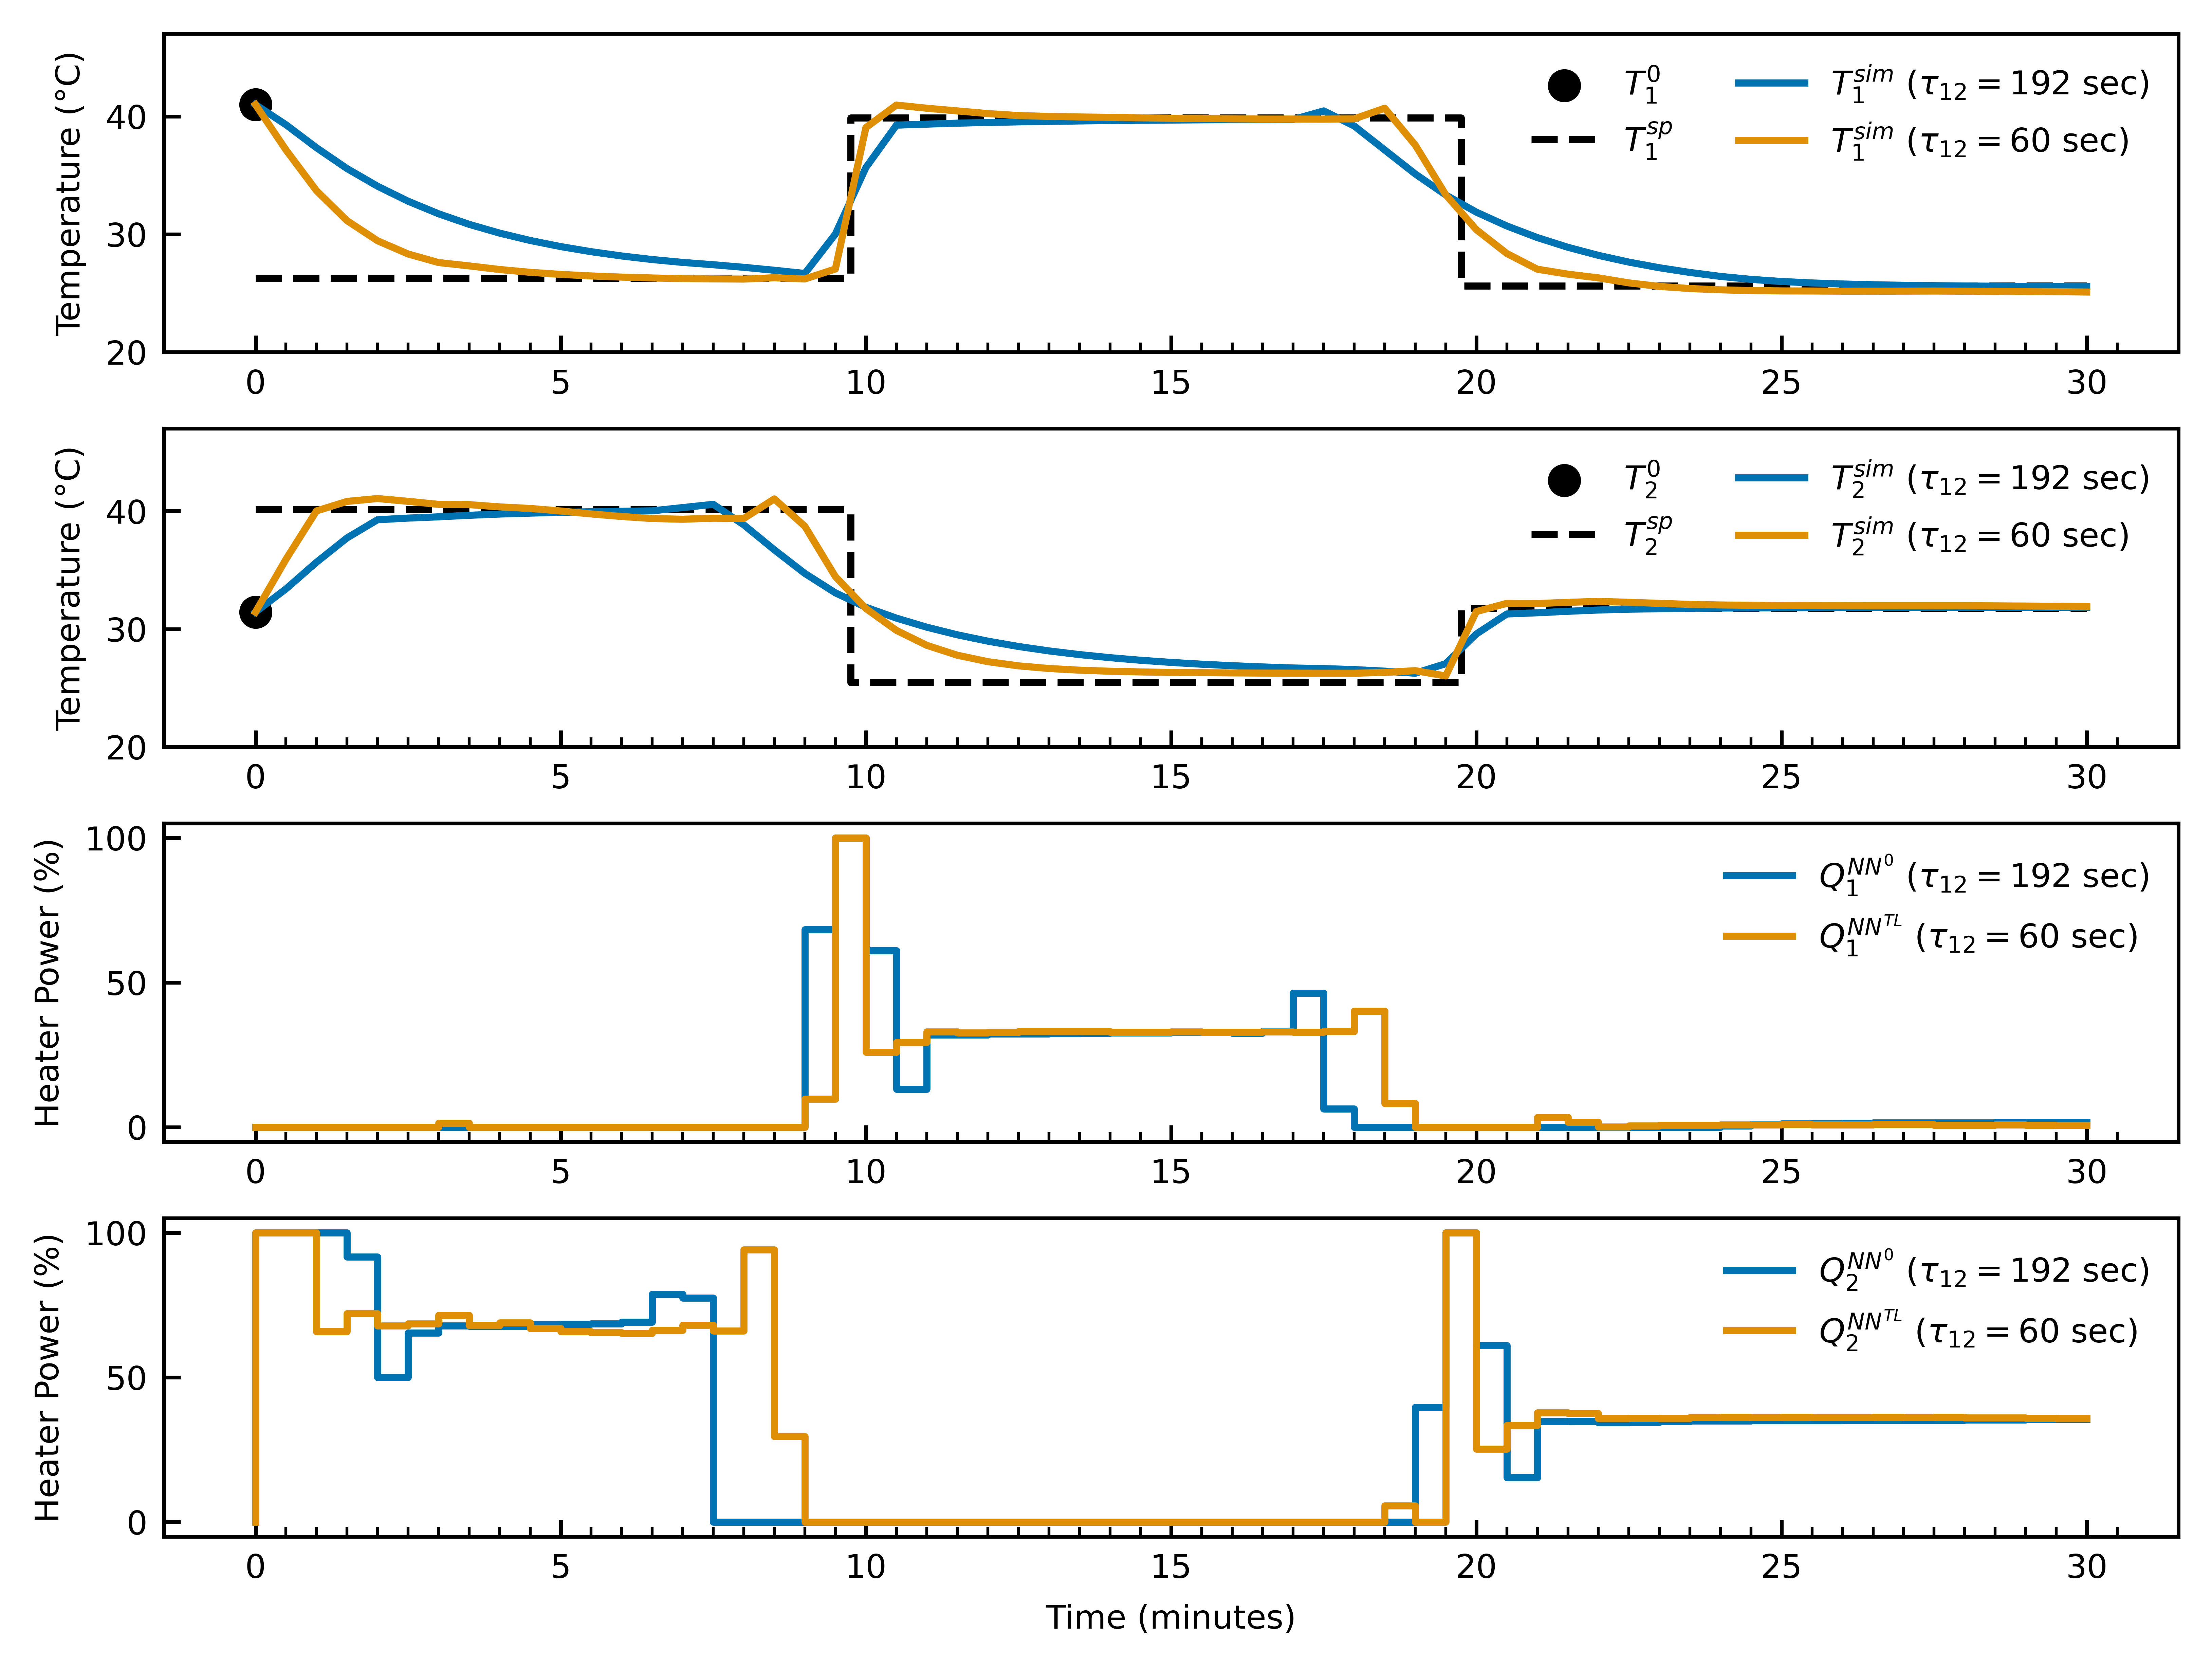

In [30]:
# colors = plt.colormaps["tab20c"].colors
import seaborn as sns

colors = sns.color_palette("colorblind", 2)
# sp1_color = colors[0]
sp1_color = "black"
# sp2_color = colors[8]
sp2_color = "black"
t1_sys1_color = colors[0]
t2_sys1_color = colors[0]
t1_sys2_color = colors[1]
t2_sys2_color = colors[1]

t10, t20, t1sp, t2sp, q1, q2 = test_dataset.__getitem__(1)

NN = torch.load("TCLab_NNv0.pt", weights_only=False)
NNtl = torch.load("TCLab_NNv0_tl.pt", weights_only=False)
q1_p_sys1, q2_p_sys1 = NN(t10, t20, t1sp, t2sp)
q1_p_sys2, q2_p_sys2 = NNtl(t10, t20, t1sp, t2sp)

t10 = test_dataset._Tunscale(t10).numpy()
t20 = test_dataset._Tunscale(t20).numpy()
t1sp = test_dataset._Tunscale(t1sp).numpy()
t2sp = test_dataset._Tunscale(t2sp).numpy()
q1_p_sys1 = test_dataset._Qunscale(q1_p_sys1).detach().numpy()
q2_p_sys1 = test_dataset._Qunscale(q2_p_sys1).detach().numpy()
q1_p_sys2 = test_dataset._Qunscale(q1_p_sys2).detach().numpy()
q2_p_sys2 = test_dataset._Qunscale(q2_p_sys2).detach().numpy()

tc1_sys1, tc2_sys1 = tclab_sim(t10, t20, q1_p_sys1, q2_p_sys1)
tc1_sys2, tc2_sys2 = tclab_sim(t10, t20, q1_p_sys2, q2_p_sys2, tau12=60)

fig, ax = plt.subplots(4, 1)

ax[0].scatter(0, t10, color=sp1_color, marker="o", label=r"$T_1^0$")
# ax[0].scatter(0, t20, color=sp2_color, marker="o", label=r"$T_2^0$")
ax[0].step(t, t1sp, color=sp1_color, linestyle="--", where="mid", label=r"$T_1^{sp}$")
# ax[0].step(t, t2sp, color=sp2_color, linestyle="-", where="mid", label=r"$T_2^{sp}$")
ax[0].plot(t, tc1_sys1, color=t1_sys1_color, linestyle="-", label=r"$T_1^{sim}$ ($\tau_{12}=192$ sec)")
# ax[0].plot(t, tc2_sys1, color=t2_sys1_color, linestyle="-", label=r"$T_2^{sim}$ (sys2)")
ax[0].plot(t, tc1_sys2, color=t1_sys2_color, linestyle="-", marker="none", label=r"$T_1^{sim}$ ($\tau_{12}=60$ sec)")
# ax[0].plot(t, tc2_sys2, color=t2_sys2_color, linestyle="-", marker="x", label=r"$T_2^{sim}$ (sys2)")
ax[0].set_xticks(np.arange(0, 30 + 1, 5))
ax[0].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[0].legend(loc="upper right", ncol=2, edgecolor="none")
ax[0].set_ylabel("Temperature (°C)")
ax[0].set_ylim(20, 47)

# ax[1].scatter(0, t10, color=sp1_color, marker="o", label=r"$T_1^0$")
ax[1].scatter(0, t20, color=sp2_color, marker="o", label=r"$T_2^0$")
# ax[1].step(t, t1sp, color=sp1_color, linestyle="-", where="mid", label=r"$T_1^{sp}$")
ax[1].step(t, t2sp, color=sp2_color, linestyle="--", where="mid", label=r"$T_2^{sp}$")
# ax[1].plot(t, tc1_sys1, color=t1_sys1_color, linestyle="-", label=r"$T_1^{sim}$ (sys1)")
ax[1].plot(t, tc2_sys1, color=t2_sys1_color, linestyle="-", label=r"$T_2^{sim}$ ($\tau_{12}=192$ sec)")
# ax[1].plot(t, tc1_sys2, color=t1_sys2_color, linestyle="-", marker="x", label=r"$T_1^{sim}$ (sys2)")
ax[1].plot(t, tc2_sys2, color=t2_sys2_color, linestyle="-", marker="none", label=r"$T_2^{sim}$ ($\tau_{12}=60$ sec)")
ax[1].set_xticks(np.arange(0, 30 + 1, 5))
ax[1].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[1].legend(loc="upper right", ncol=2, edgecolor="none")
ax[1].set_ylabel("Temperature (°C)")
ax[1].set_ylim(20, 47)

ax[2].step(t, q1_p_sys1, color=t1_sys1_color, linestyle="-", label=r"$Q_1^{NN^0}$ ($\tau_{12}=192$ sec)")
ax[3].step(t, q2_p_sys1, color=t2_sys1_color, linestyle="-", label=r"$Q_2^{NN^0}$ ($\tau_{12}=192$ sec)")
ax[2].step(t, q1_p_sys2, color=t1_sys2_color, linestyle="-", label=r"$Q_1^{NN^{TL}}$ ($\tau_{12}=60$ sec)")
ax[3].step(t, q2_p_sys2, color=t2_sys2_color, linestyle="-", label=r"$Q_2^{NN^{TL}}$ ($\tau_{12}=60$ sec)")
ax[2].set_xticks(np.arange(0, 30 + 1, 5))
ax[2].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
ax[2].legend(loc="upper right", ncol=1, edgecolor="none")
ax[3].legend(loc="upper right", ncol=1, edgecolor="none")
ax[2].set_ylabel("Heater Power (%)")
ax[3].set_ylabel("Heater Power (%)")
ax[3].set_xlabel("Time (minutes)")
ax[3].set_xticks(np.arange(0, 30 + 1, 5))
ax[3].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)

fig.savefig("TwoSystems.png", dpi=300)
plt.show()

In [31]:
TRANSFER_SCENARIO = "transfer-tau12(60)"


def plot_scenarios(logger, transfer_scenario, startswith=""):
    train_loss_v0 = logger.get_dataset("training/v0/loss/train").mean()
    test_loss_v0 = logger.get_dataset("training/v0/loss/test").mean()
    no_maintenance_train_loss_v0 = logger.get_dataset(transfer_scenario + "/No Maintenance/train/loss").mean()
    no_maintenance_test_loss_v0 = logger.get_dataset(transfer_scenario + "/No Maintenance/test/loss").mean()

    trials = [t for t in logger.get_keys(transfer_scenario) if t.startswith(startswith)]
    trials = sorted(trials, key=lambda x: int(x.split("_")[-1] if "_" in x else 0))
    for trial in trials:
        train_loss = logger.get_dataset(f"{transfer_scenario}/{trial}/train_loss")
        test_loss = logger.get_dataset(f"{transfer_scenario}/{trial}/test_loss")
        bs = logger.get_dataset(f"{transfer_scenario}/{trial}/batch size")
        lr = logger.get_dataset(f"{transfer_scenario}/{trial}/lr")
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax.plot(train_loss, label="Training loss")
        ax.plot(test_loss, label="Test loss")
        ax.hlines([train_loss_v0, test_loss_v0], 0, len(train_loss), linestyles="dashed", colors="gray")
        ax.hlines(
            [no_maintenance_train_loss_v0, no_maintenance_test_loss_v0],
            0,
            len(train_loss),
            linestyles="dashed",
            colors="red",
        )
        ax.legend()
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"{trial}: Batch Size: {bs}, Learning Rate: {lr:.4e}")
        plt.show()


def get_scenario_data(logger, scenario):
    final_train_loss = logger.get_dataset(f"{scenario}/train_loss")[-1]
    final_test_loss = logger.get_dataset(f"{scenario}/test_loss")[-1]
    bs = logger.get_dataset(f"{scenario}/batch size")
    lr = logger.get_dataset(f"{scenario}/lr")
    return {
        "train loss": final_train_loss,
        "test loss": final_test_loss,
        "batch size": bs,
        "learning rate": lr,
    }


method = "Batched Adam"
# plot_scenarios(logger, f"{TRANSFER_SCENARIO}/{method}", startswith="")

In [32]:
methods = [k for k in logger.get_keys(TRANSFER_SCENARIO) if k != "No Maintenance"]
methods = ["New NN - Batched Adam", "Batched Adam", "Masked Adam"]
data = []
data.append(
    {
        "method": "Original",
        "best_trial": np.nan,
        "train_loss": logger.get_dataset("training/v0/loss/train").min(),
        "test_loss": logger.get_dataset("training/v0/loss/test")[
            np.argmin(logger.get_dataset("training/v0/loss/train"))
        ],
    }
)
data.append(
    {
        "method": "No Maintenance",
        "best_trial": np.nan,
        "train_loss": logger.get_dataset(TRANSFER_SCENARIO + "/No Maintenance/train/loss").mean(),
        "test_loss": logger.get_dataset(TRANSFER_SCENARIO + "/No Maintenance/test/loss").mean(),
    }
)
for method in methods:
    row_data = {}
    row_data["method"] = method
    row_data["best_trial"], row_data["train_loss"], row_data["test_loss"] = identify_best_trial(
        f"{TRANSFER_SCENARIO}/{method}"
    )
    data.append(row_data)

In [33]:
colors = plt.colormaps["tab20"].colors

# Batched Adam
# New NN
# Masked Adam
# Subset SEKF (?)


def grouped_bars(midx, train_data, test_data, ax):
    bar_width = 0.3
    train_color = colors[0]
    test_color = colors[2]

    bar1 = ax.bar(midx - bar_width / 2, train_data.mean(), width=bar_width, color=train_color)
    bar2 = ax.bar(midx + bar_width / 2, test_data.mean(), width=bar_width, color=test_color)
    return bar1, bar2


with plt.rc_context(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
):
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    # fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    for i, d in enumerate(data):
        bar1, bar2 = grouped_bars(i, d["train_loss"], d["test_loss"], ax)

    # ax.set_xticks(np.arange(len(data)), labels=[d["method"] for d in data])
    labels = [
        "Original NN",
        "Original NN",
        "New NN",
        "Transfer Learning:\nAdam",
        "Transfer Learning:\nMasked Adam",
    ]
    # xlim = ax.get_xlim()
    # ylim = ax.get_ylim()
    ax.fill_betweenx([0, 0.3], -1, 0.5, color="lightgray", zorder=0)
    ax.set_xlim(-0.53, 4.53)
    ax.set_ylim(0.0001, 0.04)
    # ax.set_ylim(0, 0.1)
    ax.legend(
        [bar1, bar2],
        ["Train Loss", "Test Loss"],
        loc="upper right",
        edgecolor="none",
    )
    ax.annotate(r"$\tau =$192 sec" + f"\n{2**16:,} examples", xy=(0, 9e-3), ha="center")
    ax.annotate(
        r"$\tau =$60 sec" + f"\n{2**10:,} examples",
        xy=(2.5, 9e-3),
        ha="center",
    )
    ax.set_xticks(np.arange(len(data)), labels=labels)
    ax.set_yscale("log")
    ax.set_ylabel("Loss")


In [5]:
data = []
for trial_name in logger.get_keys(TRANSFER_SCENARIO + "/Masked Adam"):
    try:
        train_loss = logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/train_loss").min()
        test_loss = logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/test_loss")[
            np.argmin(logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/train_loss"))
        ]
        lr = logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/lr")
        bs = logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/batch size")
        mask_ratio = logger.get_dataset(f"{TRANSFER_SCENARIO}/Masked Adam/{trial_name}/mask ratio")
        data.append(
            {
                "trial": trial_name,
                "train_loss": train_loss,
                "test_loss": test_loss,
                "batch size": bs,
                "learning rate": lr,
                "mask ratio": mask_ratio,
            }
        )
    except Exception as e:
        print(f"Error processing trial {trial_name}: {e}")
        continue
data = pd.DataFrame(data)
data = data.sort_values(by="train_loss")
data

ERROR:root:KeyError: Dataset transfer-tau12(60)/Masked Adam/trial/train_loss not found.


Error processing trial trial: 'NoneType' object has no attribute 'min'


trial  train_loss                test_loss  batch size  \
93   trial_183    0.000564  [0.0005747904069721699]           5   
63   trial_156    0.000644  [0.0006940893945284188]          25   
91   trial_181    0.000722  [0.0007721959846094251]           5   
33   trial_129    0.000734  [0.0007616554503329098]          25   
65   trial_158    0.000831  [0.0008731677662581205]          25   
..         ...         ...                      ...         ...   
133    trial_3    0.121389    [0.12148142606019974]           5   
144    trial_4    0.123346    [0.12344587594270706]           5   
111    trial_2    0.130985    [0.13111409544944763]           5   
166    trial_6    0.152479    [0.15214551985263824]          25   
0      trial_1    0.303203    [0.30292800068855286]           5   

     learning rate  mask ratio  
93         0.00001        0.90  
63         0.00003        0.50  
91         0.00001        0.50  
33         0.00010        0.95  
65         0.00003        0.90  
..             ...         ...  
133        0.01000        0.90  
144        0.01000        0.95  
111        0.01000        0.80  
166        0.01000        0.50  
0          0.01000        0.50  

[210 rows x 6 columns]

In [16]:
TRANSFER_SCENARIO = "transfer-tau12(60)"
loss_fn = lambda q1, q2, Q1, Q2: torch.mean((q1 - Q1) ** 2 + (q2 - Q2) ** 2)

NNtl = torch.load("TCLab_NNv0.pt", weights_only=False)
LR = 1e-5
BATCH_SIZE = 5
MASK_RATIO = 0.9
tl_dataset = TCLabDataset(logger, prefix=f"data/{TRANSFER_SCENARIO}/")
t10_, t20_, t1sp_, t2sp_, q1_, q2_ = tl_dataset.get_all()
EPOCHS = 2000
dataloader = torch.utils.data.DataLoader(tl_dataset, batch_size=BATCH_SIZE, shuffle=True)
opt = maskedAdam(NNtl.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.4, patience=20)
trail_key = logger.get_unique_key(f"{TRANSFER_SCENARIO}/Masked Adam/trial/")
# logger.log_attribute(trail_key + "batch size", BATCH_SIZE)
# logger.log_attribute(trail_key + "lr", LR)
# logger.log_attribute(trail_key + "epochs", EPOCHS)
# logger.log_attribute(trail_key + "mask ratio", MASK_RATIO)
for epoch in range(EPOCHS):
    for t10, t20, t1sp, t2sp, q1, q2 in dataloader:
        q1_p, q2_p = NNtl(t10, t20, t1sp, t2sp)
        loss = loss_fn(q1_p, q2_p, q1, q2)
        loss.backward()
        grads = opt._get_flat_grads()
        mask = mask_fn(grads, quantile_thresh=MASK_RATIO)
        opt.masked_step(mask=mask)

    with torch.no_grad():
        q1_p_, q2_p_ = NN(t10_, t20_, t1sp_, t2sp_)
        train_loss = loss_fn(q1_p_, q2_p_, q1_, q2_)
    #     q1_p_t, q2_p_t = NN(t10_t, t20_t, t1sp_t, t2sp_t)
    #     test_loss = loss_fn(q1_p_t, q2_p_t, q1_t, q2_t)
    lr_scheduler.step(train_loss)

    # logger.log_dict(
    #     {
    #         trail_key + "train_loss": train_loss.item(),
    #         trail_key + "test_loss": test_loss.item(),
    #         # trail_key + "lr": lr_scheduler.get_last_lr()[0],
    #     }
    # )

In [17]:
torch.save(NNtl, "TCLab_NNv0_tl.pt")

In [34]:
2**16

65536